# Stroke prediction dataset

First, import basic libraries and open dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
stroke_df = pd.read_csv('data/stroke/healthcare-dataset-stroke-data.csv')
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
stroke_df.rename({'Residence_type': 'residence_type'}, inplace=True)
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 519.0+ KB


We aren't going to need patients' id; we should also make categorical values'
representation concise

In [4]:
stroke_df.drop(columns=['id'], inplace=True)
stroke_df['hypertension'] = stroke_df['hypertension'].map({1: 'Yes', 0: 'No'})
stroke_df['heart_disease'] = stroke_df['heart_disease'].map({1: 'Yes', 0: 'No'})
stroke_df['stroke'] = stroke_df['stroke'].astype(str)
stroke_df.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


In [5]:
stroke_df.describe(include=['O'])

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
count,5110,5110,5110,5110,5110,5110,5110,5110
unique,3,2,2,2,5,2,4,2
top,Female,No,No,Yes,Private,Urban,never smoked,0
freq,2994,4612,4834,3353,2925,2596,1892,4861


In [6]:
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,No,No,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
stroke_df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [8]:
stroke_df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

This third gender can cause bias in the future; we should get rid of it

In [9]:
stroke_df = stroke_df.loc[stroke_df.loc[:, 'gender'] != 'Other']
stroke_df.describe()

,age,avg_glucose_level,bmi
count,5109.000000,5109.000000,4908.00000
mean,43.229986,106.140399,28.89456
std,22.613575,45.285004,7.85432
min,0.080000,55.120000,10.30000
25%,25.000000,77.240000,23.50000
50%,45.000000,91.880000,28.10000
75%,61.000000,114.090000,33.10000
max,82.000000,271.740000,97.60000


Let's see what's in our data

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

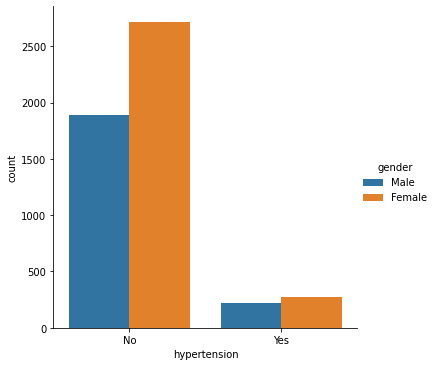

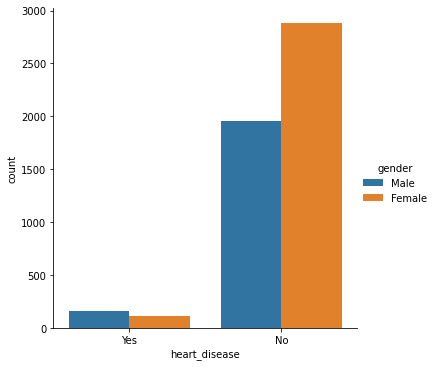

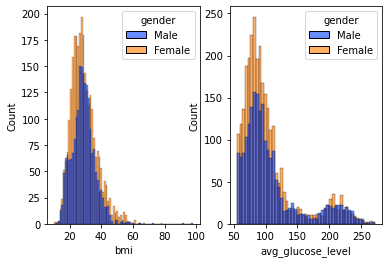

In [10]:
sns.catplot(x='hypertension', hue='gender', kind='count', data=stroke_df)
sns.catplot(x='heart_disease', hue='gender', kind='count', data=stroke_df)
fig, ax = plt.subplots(1,2)
sns.histplot(x='bmi', hue='gender', alpha=.6, palette='bright', data=stroke_df, ax=ax[0])
sns.histplot(x='avg_glucose_level', hue='gender', alpha=.6, palette='bright', data=stroke_df, ax=ax[1])

Of course checking for correlations is also helpful

<AxesSubplot:>

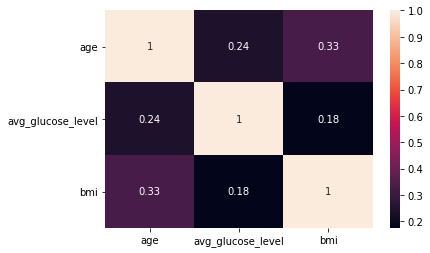

In [11]:
corr_matrix = stroke_df.corr()
sns.heatmap(data=corr_matrix, annot=True)

I think we can move on to data preparation

In [12]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

In [13]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

As our data is imbalanced and there is not very much of the data, we have to do
some oversampling <br>
We can try fitting imbalanced data into gradient boosting model, however

In [14]:
num_columns = ['age', 'avg_glucose_level', 'bmi']
cat_columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
 'Residence_type', 'smoking_status']

In [15]:
X = stroke_df.drop(columns=['stroke'])
y = stroke_df.loc[:, 'stroke']

In [16]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('std_scaler', StandardScaler())
])
transformer = ColumnTransformer([
    ('num', num_pipeline, num_columns),
    ('cat', OneHotEncoder(), cat_columns)
])

X_train_imbalanced, X_test_imbalanced, y_train_imbalanced, y_test_imbalanced =\
    train_test_split(X, y, random_state=42)
X_train_imbalanced = transformer.fit_transform(X_train_imbalanced)
X_test_imbalanced = transformer.transform(X_test_imbalanced)

In [20]:
gb_param_grid = [{'n_estimators': [140, 160, 180], 'max_depth': [5, 7, 9], 'criterion':
                      ['friedman_mse', 'mse']}]
gb_grid = GridSearchCV(GradientBoostingClassifier(), param_grid=gb_param_grid, cv=5
                       ,scoring='roc_auc')
gb_grid.fit(X_train_imbalanced, y_train_imbalanced)
gb_grid.score(X_test_imbalanced, y_test_imbalanced)

0.7946160267111855

In [21]:
gb_grid.best_params_

{'criterion': 'friedman_mse', 'max_depth': 5, 'n_estimators': 160}

In [17]:
from imblearn.over_sampling import RandomOverSampler

In [18]:
oversampler = RandomOverSampler(sampling_strategy='minority')
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, random_state=42)

In [20]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [21]:
y_train = y_train.astype(np.float)
y_test = y_test.astype(np.float)
y_train

9448    1.0
3111    0.0
9013    1.0
8121    1.0
1701    0.0
       ... 
5734    1.0
5191    1.0
5390    1.0
860     0.0
7270    1.0
Name: stroke, Length: 7290, dtype: float64

In [26]:
forest_param_grid = [{'n_estimators': [140, 160, 180], 'max_depth': [9,11,13], 'criterion':
                      ['gini', 'entropy']}]
forest_grid = GridSearchCV(RandomForestClassifier(), param_grid=forest_param_grid, cv=5
                       ,scoring='roc_auc')
forest_grid.fit(X_train, y_train)
forest_grid.score(X_test, y_test)

0.9996687416042255

In [27]:
forest_grid.best_params_

{'criterion': 'gini', 'max_depth': 13, 'n_estimators': 140}

In [28]:
gb_grid.fit(X_train, y_train)
gb_grid.score(X_test, y_test)

1.0

In [29]:
gb_grid.best_params_

{'criterion': 'mse', 'max_depth': 9, 'n_estimators': 160}

In [30]:
log_reg_param_grid = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e4]}]
log_reg_grid = GridSearchCV(LogisticRegression(), param_grid=log_reg_param_grid, cv=5
                       ,scoring='roc_auc')
log_reg_grid.fit(X_train, y_train)
log_reg_grid.score(X_test, y_test)

0.8580479870802451

In [31]:
log_reg_grid.best_params_

{'C': 10000.0}

In [32]:
svc_param_grid = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e4]}]
svc_reg_grid = GridSearchCV(LinearSVC(dual=False), param_grid=svc_param_grid, cv=5
                       ,scoring='roc_auc')
svc_reg_grid.fit(X_train, y_train)
svc_reg_grid.score(X_test, y_test)

0.8582498582498582

In [33]:
log_reg_grid.best_params_

{'C': 10000.0}

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

In [91]:
model = Sequential()
model.add(Dense(32, input_dim=22, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate=.1))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [93]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC()])

In [94]:
callback = EarlyStopping(monitor='loss', min_delta=.001, patience=5)
model.fit(X_train, y_train, epochs=150, batch_size=100, callbacks=[callback])

Epoch 1/150
73/73 [==============================] - 2s 9ms/step - loss: 0.6698 - auc: 0.6278

In [95]:
model.evaluate(X_test, y_test)

76/76 [==============================] - 1s 6ms/step - loss: 0.2100 - auc: 0.9598


[0.20997950434684753, 0.9597764611244202]

We can see that a neural network performs very well but not as well as gradient
boosting algorithm or even random forest. This may be due to relatively small number
of samples in our dataset